In [1]:
projectdir = "C:/Users/arman/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia/"
cd(projectdir)
using Pkg; Pkg.activate(pwd())

using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings, LsqFit, CSV, Pipe, ProgressMeter, StatsPlots, BSON
using Distributions, NLsolve, Roots
pyplot()

try
    Turnover
catch e
    include(projectdir*"Turnover/src/Turnover.jl")
    include(projectdir*"Turnover/src/test.jl")
    using .Turnover
end
try
    SeqDataFormatting
catch e
    include("experimental_data/SeqDataFormatting.jl")
    import .SeqDataFormatting
end

import TumorGrowth
include("distribution_functions.jl")
plot(size=(1,1))

  Activating environment at `C:\Users\arman\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`

Test Summary:             | Pass  Total
Applying turnover methods |    7      7


# Ling data

In [2]:
sanger = TumorGrowth.data_import("experimental_data/LingProcessed/experimental_data_Sanger.csv"; delim="\t")
sanger.frequencies = [ones(Float64, length(m)) for m in sanger.mutations];

In [3]:
wes = TumorGrowth.data_import("experimental_data/LingProcessed/experimental_data_WES.csv", delim="\t");

In [4]:
sanger_lichee = TumorGrowth.data_import("experimental_data\\LingProcessed\\experimental_data_Sanger_clones.csv", delim="\t")
sanger_coinc = TumorGrowth.data_import("experimental_data\\LingProcessed\\experimental_data_Sanger_clones_coinc.csv", delim="\t")
lichee_tree = BSON.load("experimental_data\\LingProcessed\\lichee_tree_Sanger.bson")
sanger_lichee.frequencies = map( ones∘length, sanger_lichee.mutations)
sanger_coinc.frequencies = map( ones∘length, sanger_coinc.mutations)
;

In [5]:
wes_freqs = SeqDataFormatting.mfreqs(wes) |> df -> Dict(df.mutation .=> df.frequency)
sanger_freqs = TumorGrowth.mutation_freqs(sanger) |> df -> Dict(df.mutation .=> df.frequency);

## Sanger: *sanger 'frequencies'*

> ***set thresholds***

In [9]:
r = 30.15 / 2
min_samples = 3
n = nrow(sanger)
R = sqrt( n * r^2 / (π/(2*√3)) )
N = (R/r)^3 * π/(3*√2) / min_samples

1375.0572522077164

In [10]:
tumor = deepcopy(sanger_lichee)
turnover_params = (
    f_min = 1 / floor(nrow(sanger)/min_samples),
    N = N,
    )
freqs = TumorGrowth.mutation_freqs(sanger) |> df -> Dict(df.mutation .=> df.frequency)
;

### single call

In [11]:
orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > turnover_params[:f_min],
            tumor.mutations) ) )
    
# get d
W_l = orphaned_red_treeless(orphaned_tumor) |> 
    df -> sum( df.isorphaned ) / sum( df.isgreen )

# d_solve = min(1., 2*log(turnover_params[:Nthresh_orph])*W_l)
d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; 
            N= turnover_params[:N] * (1-x))) - W_l,
            0.01, 0.999) 

0.9927975988776796

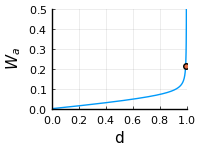

In [12]:
plot(0:0.001:1., x -> Turnover.W_orphaned( x; N= turnover_params[:N]*(1-x) ), xlim=(0,1), ylim=(0,0.5), size=(200,150), lab=:none)
scatter!([d_solve], [W_l], lab=:none, xlab=:d, ylab=L"W_a")

In [13]:
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > turnover_params[:f_min] for m in muts), tumor.mutations) )

# get mu
W_c = estranged_treeless(estranged_tumor) |> 
        df -> sum( df.isestranged ) / sum( df.isgreen )

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu,
            T=log(turnover_params[:N]*(1-d_solve)) / (1-d_solve)))- W_c, 0.0001, 0.9999)

0.001509339701125478

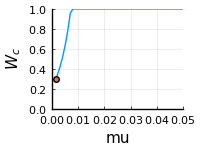

In [14]:
plot(0:0.001:0.05, mu -> min(1., W_estranged(d_solve; b=1., μ=mu, 
            T=log(turnover_params[:N]*(1-d_solve))/(1-d_solve))),
    xlim=(0,0.05), ylim=(0,1.0), size=(200,150), lab=:none)
scatter!([mu_solve], [W_c], lab=:none, xlab=:mu, ylab=L"W_c")

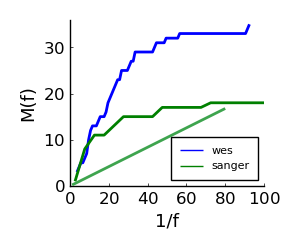

In [15]:
wes_freqs = SeqDataFormatting.mfreqs(wes).frequency

p = plot(layout=(1,1), size=(300,250), grid=false, xlab=L"1/f", ylab=L"M(f)", xlim=(0, 100),
    labelfontsize=13, tickfontsize=12, margin=5Plots.mm, legend=:bottomright)
M!(p[1], wes_freqs, nbins=50, lab="wes", lw=2., ylim=(0,36), c = :blue)
M!(p[1], collect( values(freqs) ), nbins=50, lab="sanger", lw=2., ylim=(0,36), c = :green)
plot!(p[1], 1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")

### vary samplesize

0.9927975988776796


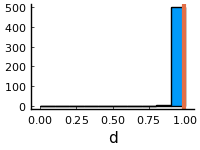

In [16]:
ds = map( 0.5:0.1:1. ) do L
    map( 1:100 ) do _
        orphaned_tumor = DataFrame( mutations = unique( 
                filter.(m-> freqs[m] > turnover_params[:f_min], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x; 
                        N= turnover_params[:N]*(1-x))) - W_l, 0.001, 0.999)
        catch e
            e isa ArgumentError && NaN
        end
    end
end
filter!.(!isnan, ds)
println(median(vcat(ds...)))
histogram(vcat(ds...), bins=0.:0.1:1., size=(200,150), lab="")
vline!([median(vcat(ds...))], lab="", lw=3., grid=false, xlab=:d)

In [17]:
d_solve=0.993

0.993

In [18]:
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > turnover_params[:f_min] for m in muts), tumor.mutations) )

# get mu
W_c = estranged_treeless(estranged_tumor) |> 
        df -> sum( df.isestranged ) / sum( df.isgreen )

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, 
            T=log(turnover_params[:N]*(1-d_solve))/(1-d_solve)))- W_c, 0.001, 0.999)

0.00142658347306374

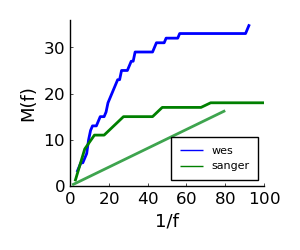

In [19]:
wes_freqs = SeqDataFormatting.mfreqs(wes).frequency

p = plot(layout=(1,1), size=(300,250), grid=false, xlab=L"1/f", ylab=L"M(f)", xlim=(0, 100),
    labelfontsize=13, tickfontsize=12, margin=5Plots.mm, legend=:bottomright)
M!(p[1], wes_freqs, nbins=50, lab="wes", lw=2., ylim=(0,36), c = :blue)
M!(p[1], collect( values(freqs) ), nbins=50, lab="sanger", lw=2., ylim=(0,36), c = :green)
plot!(p[1], 1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")

In [155]:
ds = map( 0.5:0.1:1. ) do L
   map( 1:10 ) do _
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > turnover_params[:f_min], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x; N= turnover_params[:N] * (1-x) )) - W_l, 0.001, 0.999)
        catch e
            e isa ArgumentError && 1.
        end
    end
end;

mean fit : 0.0033583341802004845
averaged fits : 0.0032308376140633664 ± 7.544154399087276e-5


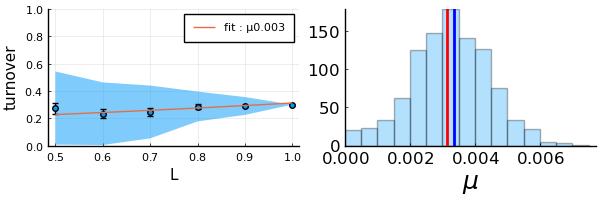

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [156]:
let d = d_solve
    Ls = 0.5:0.1:1.
    reps = 50
    estranged_tumors = map( Ls ) do L
        [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
    end

    estranged_turnover = map(estranged_tumors) do set
            filter!(!isnan, map(set) do tumor
                res = estranged_treeless(tumor)
                sum( res.isestranged ) / sum( res.isgreen )
                end ) 
        end

    Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])
    
    global Nthresh
    function model(Ls, p)
        local mu = p[1]
        (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=1., μ=mu*L, 
                    T=log(turnover_params[:N]*(1-d))/(1-d)))
        end
    end
    fit = curve_fit(model, Ls, mean.(t), [(1-d)/2])
    mu_fit = fit.param[1]

    p1 = scatter( Ls, mean.(t), ribbon=std.(t), yerror = std.(t)./sqrt.(length.(t)), lab="", 
        xlab=:L, ylab=:turnover, legend=:topright, ylim=(0,1))
    plot!(Ls, model(Ls, fit.param), lab="fit : μ$(round(mu_fit,digits=3))" )

    tvecs = [ rand.(t) for _=1:1000 ]
    fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
    mu_fits = getindex.(getfield.(fits, :param),1)
    p2 = histogram( mu_fits, lab="", alpha=0.3, xlim=(0,:auto), nbins=30, size=(400,250), ylim=(0,:auto))
    vline!([mu_fit], lab="", lw=2., c=:blue, tickfontsize=12, labelfontsize=18, xlab=L"\mu", grid=false )
    vline!([mu_solve], lab="", lw=2., c=:red)

    println("mean fit : ", mu_fit)
    println("averaged fits : ", mean(mu_fits), " ± ", 1.96*std(mu_fits)/sqrt(length(mu_fits)))
    plot(p1,p2, size=(600,200))

#     savefig("Turnover/turnover_plots/experimental_data/sanger_wesfreqs_mu.pdf")
end

In [20]:
ds = map( 0.2:0.1:1. ) do L
    map( 1:100 ) do _
        orphaned_tumor = DataFrame( mutations = unique( 
                filter.(m-> freqs[m] > turnover_params[:f_min], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x;
                        N= turnover_params[:N]*(1-x))) - W_l, 0.001, 0.999)
        catch e
            e isa ArgumentError && NaN
        end
    end
end
filter!.(!isnan, ds)
ds = vcat(ds...)
d_solve = median(ds)

estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > turnover_params[:f_min] for m in muts), tumor.mutations) )
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum( df.isestranged ) / sum( df.isgreen ) 

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:N])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu,
            T=log(turnover_params[:N]*(1-d_solve))/(1-d_solve)))- W_c, 0.001, 0.999)

Ls = 0.4:0.1:1.
reps = 200
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, set .|> estranged_treeless .|> df -> sum( df.isestranged ) / sum( df.isgreen ))
    end

Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1., μ=mu*L,
                T=log(turnover_params[:N]*(1-d_solve))/(1-d_solve)))
    end
end
# fitres = curve_fit(model, Ls, mean.(t), [(1-d_solve)/2])
fitres = curve_fit(model, vcat( [ fill(Ls[i], length(t_)) for (i,t_) in enumerate(t)]... ), 
    vcat(t...), [(1-d_solve)/2])
mu_fit = fitres.param[1]

tvecs = [ rand.(t) for _=1:10000 ]
fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
mu_fits = getindex.(getfield.(fits, :param),1);

0.9951707029989295
0.0009467966461068212


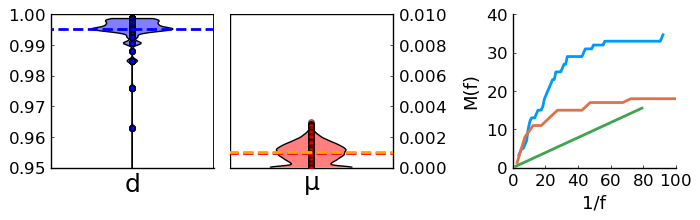

In [166]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

plot!(p[1], legend=:none, xlim=(0.2,1.8), xtickfontsize=18, ylim=(0.95,1.), xticks=([1],[L"d"]))#, xaxis=:off)
hline!(p[1], [1], c=:black)
vline!(p[1], [1.8], c=:black, lw=2)
violin!(p[1], [1], ds, c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5)
hline!(p[1], [d_solve], c=:blue, lw=2., style=:dash)
println(d_solve)

plot!(p[2], legend=:none, xlim=(0.2,1.8), xtickfontsize=18, ylim=(0,0.01), xticks=([1],[L"\mu"]), ymirror=true)#, xaxis=:off)
hline!(p[2], [0.01], c=:black)
vline!(p[2], [0.2], c=:black)
violin!(p[2], [1], mu_fits, c=:red, fillalpha=0.5)
scatter!(p[2], [1], mu_fits, c=:red, alpha=0.5)
hline!(p[2], [median(mu_fits)], c=:red, lw=2., style=:dash)
println(median(mu_fits))
hline!(p[2], [mu_solve], c=:orange, lw=2., style=:dash)

res = 1/100
plot!(p[3], tickfontsize=12, labelfontsize=13)
M!(p[3], wes_freqs, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40))
M!(p[3], collect(values(freqs)), nbins=50, lab="sanger",
    lw=2.)
plot!(p[3], 1:80, x-> x*median(mu_fits)/(1-d_solve), lw=2., lab="")

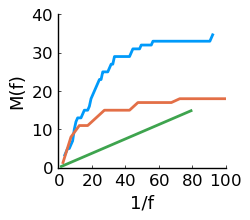

In [26]:
p = plot(layout=(1,1), size=(250,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

# plot!(p[1], legend=:none, xlim=(0.2,1.8), xtickfontsize=18, ylim=(0.95,1.), xticks=([1],[L"d"]))#, xaxis=:off)
# hline!(p[1], [1], c=:black)
# vline!(p[1], [1.8], c=:black, lw=2)
# violin!(p[1], [1], ds, c=:blue, fillalpha=0.5)
# scatter!(p[1], [1], ds, c=:blue, alpha=0.5)
# hline!(p[1], [d_solve], c=:blue, lw=2., style=:dash)
# println(d_solve)

# plot!(p[2], legend=:none, xlim=(0.2,1.8), xtickfontsize=18, ylim=(0,0.01), xticks=([1],[L"\mu"]), ymirror=true)#, xaxis=:off)
# hline!(p[2], [0.01], c=:black)
# vline!(p[2], [0.2], c=:black)
# violin!(p[2], [1], mu_fits, c=:red, fillalpha=0.5)
# scatter!(p[2], [1], mu_fits, c=:red, alpha=0.5)
# hline!(p[2], [median(mu_fits)], c=:red, lw=2., style=:dash)
# println(median(mu_fits))
# hline!(p[2], [mu_solve], c=:orange, lw=2., style=:dash)

res = 1/100
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], wes_freqs, nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40))
M!(p[end], collect(values(freqs)), nbins=50, lab="sanger",
    lw=2.)
plot!(p[end], 1:80, x-> x*median(mu_fits)/(1-d_solve), lw=2., lab="")

In [27]:
name = "lichee_sangerfreqs_sottoriva"
savefig("Turnover\\turnover_plots\\inference\\"* name * ".pdf")
savefig("Turnover\\turnover_plots\\inference\\"* name * ".png")

## Sanger: *wes frequencies*

In [28]:
turnover_params = ( f_min = 1/20, Nthresh_orph = 95, Nthresh_estr = 95, )

freqs = SeqDataFormatting.mfreqs(wes) |> df -> Dict(df.mutation .=> df.frequency)


tumor = deepcopy(sanger_lichee)
# tumor = deepcopy(sanger)
# filter!.(m -> m in mutations, tumor.mutations);

### single call

In [29]:
orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > turnover_params[:f_min],
            tumor.mutations) ) )
    
# get d
W_l = orphaned_red_treeless(orphaned_tumor) |> 
    df -> sum( df.isorphaned ) / sum( df.isgreen )

# d_solve = min(1., 2*log(turnover_params[:Nthresh_orph])*W_l)
d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; 
            N= turnover_params[:Nthresh_orph] * (1-x))) - W_l,
            0.01, 0.99) 

0.9021732655808363

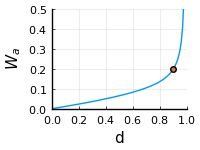

In [30]:
plot(0:0.01:1., x -> Turnover.W_orphaned( x; N= turnover_params[:Nthresh_orph]*(1-x) ), xlim=(0,1), ylim=(0,0.5), size=(200,150), lab=:none)
scatter!([d_solve], [W_l], lab=:none, xlab=:d, ylab=L"W_a")

In [31]:
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > turnover_params[:f_min] for m in muts), tumor.mutations) )

# get mu
W_c = estranged_treeless(estranged_tumor) |> 
        df -> sum( df.isestranged ) / sum( df.isgreen )

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu,
            T=log(turnover_params[:Nthresh_estr] *(1-d_solve)) / (1-d_solve)))- W_c, 0.001, 0.999)

0.020961984079945387

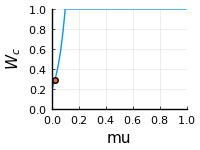

In [171]:
plot(0:0.001:1., mu -> min(1., W_estranged(d_solve; b=1., μ=mu, 
            T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve))),
    xlim=(0,1), ylim=(0,1.0), size=(200,150), lab=:none)
scatter!([mu_solve], [W_c], lab=:none, xlab=:mu, ylab=L"W_c")

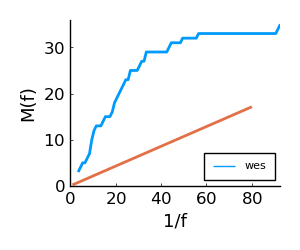

In [172]:
wes_freqs = SeqDataFormatting.mfreqs(wes).frequency

p = plot(layout=(1,1), size=(300,250), grid=false, xlab=L"1/f", ylab=L"M(f)", xlim=(0, :auto),
    labelfontsize=13, tickfontsize=12, margin=5Plots.mm, legend=:bottomright)
M!(p[1], wes_freqs, nbins=50, lab="wes", lw=2., ylim=(0,36))
plot!(p[1], 1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")

### vary samplesize

0.9021732655808363


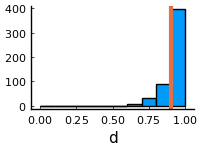

In [173]:
ds = map( 0.5:0.1:1. ) do L
    map( 1:100 ) do _
        orphaned_tumor = DataFrame( mutations = unique( 
                filter.(m-> freqs[m] > turnover_params[:f_min], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x; 
                        N= turnover_params[:Nthresh_orph]*(1-x))) - W_l, 0.01, 0.99)
        catch e
            e isa ArgumentError && NaN
        end
    end
end
filter!.(!isnan, ds)
println(median(vcat(ds...)))
histogram(vcat(ds...), bins=0.:0.1:1., size=(200,150), lab="")
vline!([median(vcat(ds...))], lab="", lw=3., grid=false, xlab=:d)

In [174]:
d_solve=0.9

0.9

In [175]:
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > turnover_params[:f_min] for m in muts), tumor.mutations) )

# get mu
W_c = estranged_treeless(estranged_tumor) |> 
        df -> sum( df.isestranged ) / sum( df.isgreen )

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, 
            T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.01, 0.99)

0.021961748770043036

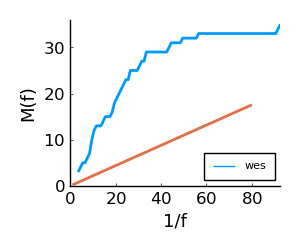

In [176]:
wes_freqs = SeqDataFormatting.mfreqs(wes).frequency

p = plot(layout=(1,1), size=(300,250), grid=false, xlab=L"1/f", ylab=L"M(f)", xlim=(0, :auto),
    labelfontsize=13, tickfontsize=12, margin=5Plots.mm, legend=:bottomright)
M!(p[1], wes_freqs, nbins=50, lab="wes", lw=2., ylim=(0,36))
plot!(p[1], 1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")

In [177]:
ds = map( 0.5:0.1:1. ) do L
   map( 1:10 ) do _
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > turnover_params[:f_min], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x; N= turnover_params[:Nthresh_orph] * (1-x) )) - W_l, 0.01, 0.99)
        catch e
            e isa ArgumentError && 1.
        end
    end
end;

mean fit : 0.019932689020081742
averaged fits : 0.0188604691692423 ± 0.0008019762822520755


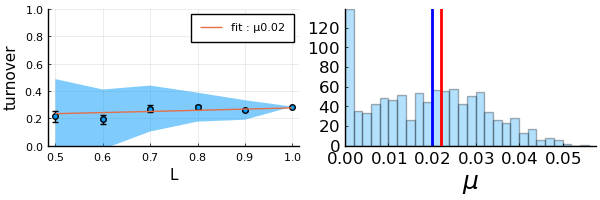

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [178]:
let d = d_solve
    Ls = 0.5:0.1:1.
    reps = 50
    estranged_tumors = map( Ls ) do L
        [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
    end

    estranged_turnover = map(estranged_tumors) do set
            filter!(!isnan, map(set) do tumor
                res = estranged_treeless(tumor)
                sum( res.isestranged ) / sum( res.isgreen )
                end ) 
        end

    Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])
    
    global Nthresh
    function model(Ls, p)
        local mu = p[1]
        (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=1., μ=mu*L, 
                    T=log(turnover_params[:Nthresh_estr]*(1-d))/(1-d)))
        end
    end
    fit = curve_fit(model, Ls, mean.(t), [(1-d)/2])
    mu_fit = fit.param[1]

    p1 = scatter( Ls, mean.(t), ribbon=std.(t), yerror = std.(t)./sqrt.(length.(t)), lab="", 
        xlab=:L, ylab=:turnover, legend=:topright, ylim=(0,1))
    plot!(Ls, model(Ls, fit.param), lab="fit : μ$(round(mu_fit,digits=3))" )

    tvecs = [ rand.(t) for _=1:1000 ]
    fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
    mu_fits = getindex.(getfield.(fits, :param),1)
    p2 = histogram( mu_fits, lab="", alpha=0.3, xlim=(0,:auto), nbins=30, size=(400,250), ylim=(0,:auto))
    vline!([mu_fit], lab="", lw=2., c=:blue, tickfontsize=12, labelfontsize=18, xlab=L"\mu", grid=false )
    vline!([mu_solve], lab="", lw=2., c=:red)

    println("mean fit : ", mu_fit)
    println("averaged fits : ", mean(mu_fits), " ± ", 1.96*std(mu_fits)/sqrt(length(mu_fits)))
    plot(p1,p2, size=(600,200))

#     savefig("Turnover/turnover_plots/experimental_data/sanger_wesfreqs_mu.pdf")
end

0.8978865285373585
0.02268745918388749


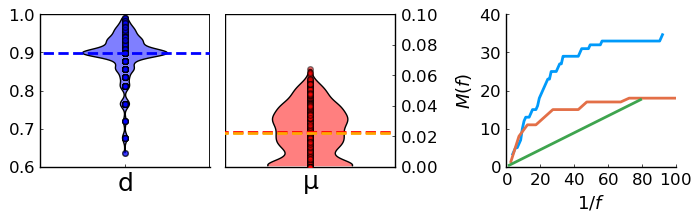

In [154]:
ds = map( 0.5:0.1:1. ) do L
    map( 1:100 ) do _
        orphaned_tumor = DataFrame( mutations = unique( 
                filter.(m-> freqs[m] > turnover_params[:f_min], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x;
                        N= turnover_params[:Nthresh_orph]*(1-x))) - W_l, 0.01, 0.99)
        catch e
            e isa ArgumentError && NaN
        end
    end
end
filter!.(!isnan, ds)
ds = vcat(ds...)
d_solve = median(ds)

estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > turnover_params[:f_min] for m in muts), tumor.mutations) )
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum( df.isestranged ) / sum( df.isgreen ) #|> mes2theory_estranged

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu,
            T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.01, 0.99)

Ls = 0.4:0.1:1.
reps = 50
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, set .|> estranged_treeless .|> df -> sum( df.isestranged ) / sum( df.isgreen ))
    end

Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1., μ=mu*L,
                T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))
    end
end
# fitres = curve_fit(model, Ls, mean.(t), [(1-d_solve)/2])
fitres = curve_fit(model, vcat( [ fill(Ls[i], length(t_)) for (i,t_) in enumerate(t)]... ), 
    vcat(t...), [(1-d_solve)/2])
mu_fit = fitres.param[1]

tvecs = [ rand.(t) for _=1:1000 ]
fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
mu_fits = getindex.(getfield.(fits, :param),1)


p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

plot!(p[1], legend=:none, xlim=(0.2,1.8), xtickfontsize=18, ylim=(0.6,1.), xticks=([1],[L"d"]))#, xaxis=:off)
hline!(p[1], [1], c=:black)
vline!(p[1], [1.8], c=:black, lw=2)
violin!(p[1], [1], ds, c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5)
hline!(p[1], [d_solve], c=:blue, lw=2., style=:dash)
println(d_solve)

plot!(p[2], legend=:none, xlim=(0.2,1.8), xtickfontsize=18, ylim=(0,0.1), xticks=([1],[L"\mu"]), ymirror=true)#, xaxis=:off)
hline!(p[2], [0.1], c=:black)
vline!(p[2], [0.2], c=:black)
violin!(p[2], [1], mu_fits, c=:red, fillalpha=0.5)
scatter!(p[2], [1], mu_fits, c=:red, alpha=0.5)
hline!(p[2], [median(mu_fits)], c=:red, lw=2., style=:dash)
println(median(mu_fits))
hline!(p[2], [mu_solve], c=:orange, lw=2., style=:dash)

res = 1/100
plot!(p[3], tickfontsize=12, labelfontsize=13)
M!(p[3], collect(values(wes_freqs)), nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40))
M!(p[3], collect(values(sanger_freqs)), nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40))
plot!(p[3], 1:80, x-> x*median(mu_fits)/(1-d_solve), lw=2., lab="")

In [41]:
ds = map( 0.5:0.1:1. ) do L
    map( 1:100 ) do _
        orphaned_tumor = DataFrame( mutations = unique( 
                filter.(m-> freqs[m] > turnover_params[:f_min], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x;
                        N= turnover_params[:Nthresh_orph]*(1-x))) - W_l, 0.01, 0.99)
        catch e
            e isa ArgumentError && NaN
        end
    end
end
filter!.(!isnan, ds)
ds = vcat(ds...)
d_solve = median(ds)

estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > turnover_params[:f_min] for m in muts), tumor.mutations) )
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum( df.isestranged ) / sum( df.isgreen ) #|> mes2theory_estranged

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu,
            T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.01, 0.99)

Ls = 0.4:0.1:1.
reps = 300
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, set .|> estranged_treeless .|> df -> sum( df.isestranged ) / sum( df.isgreen ))
    end

Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1., μ=mu*L,
                T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))
    end
end
# fitres = curve_fit(model, Ls, mean.(t), [(1-d_solve)/2])
fitres = curve_fit(model, vcat( [ fill(Ls[i], length(t_)) for (i,t_) in enumerate(t)]... ), 
    vcat(t...), [(1-d_solve)/2])
mu_fit = fitres.param[1]

tvecs = [ rand.(t) for _=1:10000 ]
fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
mu_fits = getindex.(getfield.(fits, :param),1);

0.9021732655808363
0.017496246792280734 0.020961984079945383


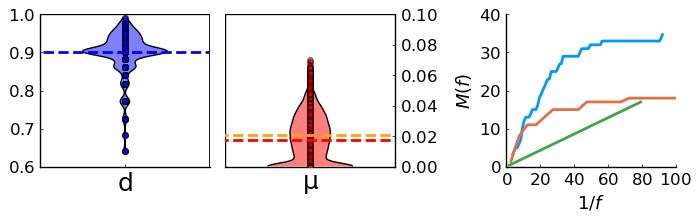

In [42]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

plot!(p[1], legend=:none, xlim=(0.2,1.8), xtickfontsize=18, ylim=(0.6,1.), xticks=([1],[L"d"]))#, xaxis=:off)
hline!(p[1], [1], c=:black)
vline!(p[1], [1.8], c=:black, lw=2)
violin!(p[1], [1], ds, c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5)
hline!(p[1], [d_solve], c=:blue, lw=2., style=:dash)
println(d_solve)

plot!(p[2], legend=:none, xlim=(0.2,1.8), xtickfontsize=18, ylim=(0,0.1), xticks=([1],[L"\mu"]), ymirror=true)#, xaxis=:off)
hline!(p[2], [0.1], c=:black)
vline!(p[2], [0.2], c=:black)
violin!(p[2], [1], mu_fits, c=:red, fillalpha=0.5)
scatter!(p[2], [1], mu_fits, c=:red, alpha=0.5)
hline!(p[2], [median(mu_fits)], c=:red, lw=2., style=:dash)
println(median(mu_fits), " ", mu_solve)
hline!(p[2], [mu_solve], c=:orange, lw=2., style=:dash)

res = 1/100
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], collect(values(wes_freqs)), nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40))
M!(p[end], collect(values(sanger_freqs)), nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40))
plot!(p[end], 1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")

In [40]:
name = "lichee_wesfreqs_sottoriva"
savefig("Turnover\\turnover_plots\\inference\\"* name * ".pdf")
savefig("Turnover\\turnover_plots\\inference\\"* name * ".png")

### vary $\mu$

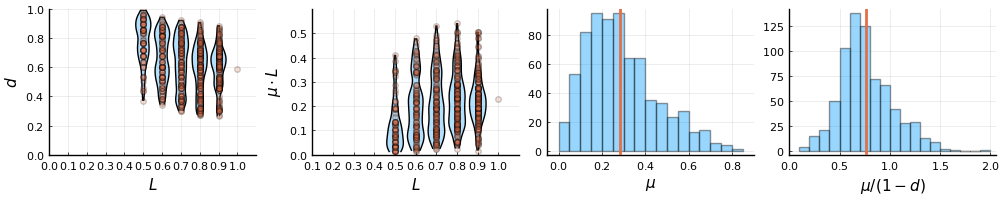

In [165]:
params = (
    f_min = 1/20,
    Nthresh_orph =90,
    Nthresh_estr = 90,
    )

freqs = SeqDataFormatting.mfreqs(wes_init) |> df -> Dict( df.mutation .=> df.frequency)
mutations = union(wes_init.mutations...)
results = Vector()
Ls = Float64[]
for L = 0.5:0.1:1.
    for _=1:200
        tumor = deepcopy(select(sanger, :mutations))
        
        selection = sample(mutations, floor(Int, length(mutations)*L), replace =false)
        filter!.(m -> m in selection, tumor.mutations)
        
        # freqs = TumorGrowth.mutation_freqs(tumor) |> df -> Dict( df.mutation .=> df.frequency)
        
        # filter!.(m-> 1.1 > freqs[m] > params[:f_min], tumor.mutations)

        htypes = unique(tumor.mutations)
        orphaned_tumor = DataFrame( mutations = unique( 
                filter.(m-> freqs[m] > params[:f_min], htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( 
                muts -> all(  freqs[m] > params[:f_min] for m in muts), htypes) )

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |>
            df -> sum(df.isorphaned)/sum(df.isgreen) 
        
        # d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)
        try
            d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; 
                N= params[:Nthresh_orph] * (1-x))) - W_l,
                0.01, 0.99)
        catch e
            d_solve = 1
        end
        
        (isnan(d_solve) || isone(d_solve) || iszero(d_solve)) && continue
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> 
            df -> sum(df.isestranged)/sum(df.isgreen) 
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, 
                        T=log(params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.01, 0.99)
            mu_solve ≈ 0.99 && continue
            
            push!(results, (d_solve, mu_solve))
            push!(Ls, L)
            L==1. && break
            catch e
        end
        
    end
end
p = plot(layout=(1,4), legend=:none, size=(1000,200))
scalex = 10

violin!(p[1], scalex*Ls, getindex.(results,1), fillalpha=0.3, xticks = ([0:scalex;], [(0:scalex) ./ scalex;]))
scatter!(p[1], scalex*Ls, getindex.(results, 1), alpha=0.2, xlim=(0,scalex*1.1), ylim=(0,1), xlab = L"L", ylab=L"d")
# hline!(p[1], [mean(getindex.(results, 1))], lw=2.)

violin!(p[2], scalex*Ls, getindex.(results,2), fillalpha=0.3, xticks = ([1:scalex;], [(1:scalex) ./ scalex;]))
scatter!(p[2], scalex*Ls, getindex.(results, 2), alpha=0.2, xlim=(4,scalex+1), ylim=(0,0.6), xlab = L"L", ylab=L"\mu\cdot L")
# plot!(p[2], [0,scalex], [0,last(results)[2]], lw=2.)

histogram!(p[3], getindex.(results, 2)./Ls, nbins=30, alpha=0.4, xlab = L"\mu")
vline!(p[3], [mean(getindex.(results, 2)./Ls)], lw=2. )

slope = filter(x -> x< 4, getindex.(results, 2)./Ls ./ (1 .- getindex.(results, 1)))

histogram!(p[4], slope, xlim=(0,:auto), nbins=30, alpha=0.4 , xlab = L"\mu/(1-d)")
vline!(p[4], [mean(slope)], lw=2. )

## Wes data

In [186]:
wes_init = TumorGrowth.data_import("experimental_data/LingProcessed/experimental_data_WES.csv", delim="\t");

In [187]:
turnover_params = ( f_min=1/20, Nthresh_orph = 95, Nthresh_estr = 95, )
filter_params =  (cutoff_low = 1/100, sample_cutoff_low = 1/3, )
# mutnumb = 100

wes = deepcopy(wes_init)
SeqDataFormatting.filter_by_freq!(wes; filter_params...)
# SeqDataFormatting.subsample!(wes; nmuts = mutnumb)
freqs = SeqDataFormatting.mfreqs(wes) |> df -> Dict( df.mutation .=> df.frequency);

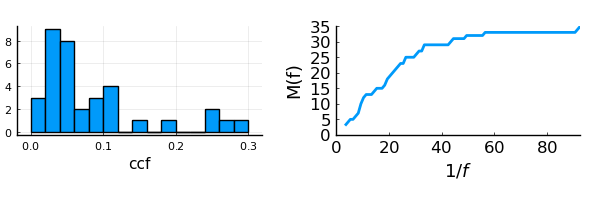

In [188]:
freqs = SeqDataFormatting.mfreqs(wes_init).frequency

p = plot(layout=(1,2), size=(600,200))
histogram!(p[1], filter( f-> 0.8 > f, freqs), nbins=20, lab="", xlab=:ccf)
M!(p[2], filter( f-> 0.8 > f > res, freqs), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    labelfontsize=13, tickfontsize=12, grid=false, margin=5Plots.mm, lw=2.,
    xlim=(0, :auto), ylim=(0,:auto))

In [189]:
htypes = unique(wes.mutations)
orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > turnover_params[:f_min], htypes) ) )
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > turnover_params[:f_min] for m in muts), htypes) )

# get d
W_l = orphaned_red_treeless(orphaned_tumor) |>
        df -> sum(df.isorphaned)/sum(df.isgreen)

d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; N= turnover_params[:Nthresh_orph] * (1-x))) - W_l,
    0.01, 0.99) 

0.8762160510544

0.8762160510544


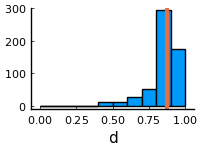

In [190]:
ds = map( 0.5:0.1:1. ) do L
    map( 1:100 ) do _
        orphaned_tumor = DataFrame( mutations = unique( 
                filter.(m-> freqs[m] > turnover_params[:f_min], wes.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x; 
                        N= turnover_params[:Nthresh_orph]*(1-x))) - W_l, 0.01, 0.99)
        catch e
            e isa ArgumentError && NaN
        end
    end
end
filter!.(!isnan, ds)
println(median(vcat(ds...)))
histogram(vcat(ds...), bins=0.:0.1:1., size=(200,150), lab="")
vline!([median(vcat(ds...))], lab="", lw=3., grid=false, xlab=:d)

In [191]:
d_solve = 0.88

0.88

In [192]:
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum(df.isestranged)/sum(df.isgreen)

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, 
            T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.01, 0.99)

0.10394503269211729

In [195]:
# get mu

Ls = 0.5:0.1:1.
reps = 10
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, map(set) do tumor
            res = estranged_treeless(tumor)
            sum(res.isestranged)/sum(res.isgreen)
        end )
    end

Ls, estranged_turnover = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1, μ=mu*L,
                T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))
    end
end

fitres = curve_fit(model, Ls, mean.(estranged_turnover), [(1-d_solve)/2])
mu_fit = fitres.param[1]


0.09906900719637682

mean fit : 0.09906900725102301
averaged fits : 0.09854510123892661 ± 0.0007669567181210474


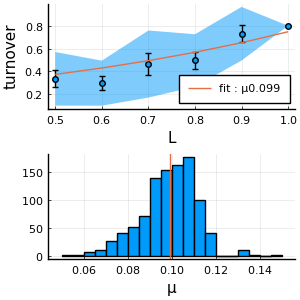

sys:1: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.0, 0.0, 1.0)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


In [196]:
let d = d_solve
    t = estranged_turnover
    global Nthresh
    function model(Ls, p)
        local mu = p[1]
        (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=1., μ=mu*L, T=log(turnover_params[:Nthresh_estr]*(1-d))/(1-d)))
        end
    end
    fit = curve_fit(model, Ls, mean.(t), [0.001])
    mu_fit = fit.param[1]

    p1 = scatter(Ls, mean.(t), ribbon=std.(t), 
        yerror = std.(t)./sqrt.(length.(t)), lab="", xlab=:L, ylab=:turnover, legend=:bottomright)
    plot!(Ls, model(Ls, fit.param), lab="fit : μ$(round(mu_fit,digits=3))" )

    tvecs = [ rand.(t) for _=1:1000 ]
    fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
    mu_fits = getindex.(getfield.(fits, :param),1)
    p2 = histogram(mu_fits, xlab="μ", lab="")
    vline!([mu_fit], lab="")

    println("mean fit : ", mu_fit)
    println("averaged fits : ", mean(mu_fits), " ± ", 1.96*std(mu_fits)/sqrt(length(mu_fits)))
    plot(p1, p2, layout=(2,1), size=(300,300))
end

In [197]:
mu_solve = 0.1

0.1

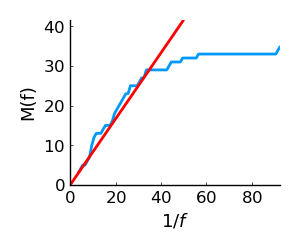

In [198]:
M(filter( f-> 0.8 > f, collect(values(wes_freqs))), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    labelfontsize=13, tickfontsize=12, grid=false, margin=5Plots.mm, lw=2., xlim=(0, :auto), ylim=(0,:auto), size=(300,250))
plot!(0:50, x-> x*mu_solve/(1-d_solve), lab="", c=:red, lw=2.)

In [199]:
ds = map( 0.5:0.1:1. ) do L
    map( 1:100 ) do _
        orphaned_tumor = DataFrame( mutations = unique( 
                filter.(m-> freqs[m] > turnover_params[:f_min], wes.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x;
                        N= turnover_params[:Nthresh_orph]*(1-x))) - W_l, 0.01, 0.99)
        catch e
            e isa ArgumentError && NaN
        end
    end
end
filter!.(!isnan, ds)
ds = vcat(ds...)
d_solve = median(ds)

estranged_tumor = DataFrame(mutations = filter( muts -> all(  
            freqs[m] > turnover_params[:f_min] for m in muts), wes.mutations) )
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum( df.isestranged ) / sum( df.isgreen ) #|> mes2theory_estranged

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu,
            T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.01, 0.99)

Ls = 0.4:0.1:1.
reps = 50
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, set .|> estranged_treeless .|> df -> sum( df.isestranged ) / sum( df.isgreen ))
    end

Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1., μ=mu*L,
                T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))
    end
end
# fitres = curve_fit(model, Ls, mean.(t), [(1-d_solve)/2])
fitres = curve_fit(model, vcat( [ fill(Ls[i], length(t_)) for (i,t_) in enumerate(t)]... ), 
    vcat(t...), [(1-d_solve)/2])
mu_fit = fitres.param[1]

tvecs = [ rand.(t) for _=1:1000 ]
fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
mu_fits = getindex.(getfield.(fits, :param),1);

0.8762160510544
0.10868847232795248 0.10736717377533075


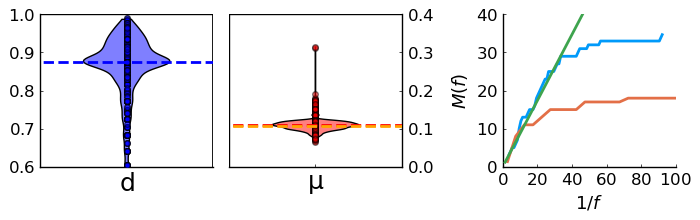

In [208]:
p = plot(layout=(1,3), size=(700,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

plot!(p[1], legend=:none, xlim=(0.2,1.8), xtickfontsize=18, ylim=(0.6,1.), xticks=([1],[L"d"]))#, xaxis=:off)
hline!(p[1], [1], c=:black)
vline!(p[1], [1.8], c=:black, lw=2)
violin!(p[1], [1], ds, c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5)
hline!(p[1], [d_solve], c=:blue, lw=2., style=:dash)
println(d_solve)

plot!(p[2], legend=:none, xlim=(0.2,1.8), xtickfontsize=18, ylim=(0,0.4), xticks=([1],[L"\mu"]), ymirror=true)#, xaxis=:off)
hline!(p[2], [0.4], c=:black)
vline!(p[2], [0.2], c=:black)
violin!(p[2], [1], mu_fits, c=:red, fillalpha=0.5)
scatter!(p[2], [1], mu_fits, c=:red, alpha=0.5)
hline!(p[2], [median(mu_fits)], c=:red, lw=2., style=:dash)
println(median(mu_fits), " ", mu_solve)
hline!(p[2], [mu_solve], c=:orange, lw=2., style=:dash)

res = 1/100
plot!(p[end], tickfontsize=12, labelfontsize=13)
M!(p[end], collect(values(wes_freqs)), nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40))
M!(p[end], collect(values(sanger_freqs)), nbins=50, lab="wes", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, 1/res ), ylim=(0,40))
plot!(p[end], 1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")

In [207]:
name = "wes_wesfreqs_sottoriva"
savefig("Turnover\\turnover_plots\\inference\\"* name * ".pdf")
savefig("Turnover\\turnover_plots\\inference\\"* name * ".png")

### vary $\mu$

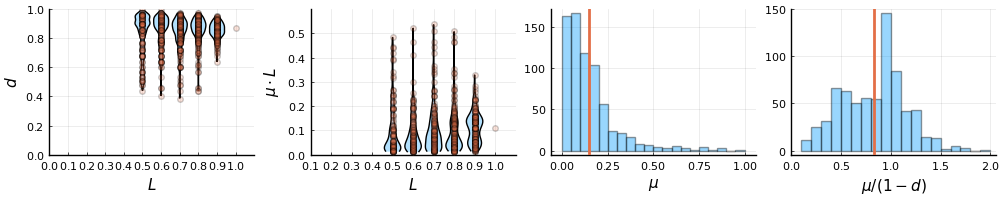

In [164]:
params = (
    f_min = 1/20,
    Nthresh_orph =90,
    Nthresh_estr = 90,
    )

freqs = SeqDataFormatting.mfreqs(wes_init) |> df -> Dict( df.mutation .=> df.frequency)
mutations = union(wes_init.mutations...)
results = Vector()
Ls = Float64[]
for L = 0.5:0.1:1.
    for _=1:200
        tumor = deepcopy(select(wes, :mutations))
        
        selection = sample(mutations, floor(Int, length(mutations)*L), replace =false)
        filter!.(m -> m in selection, tumor.mutations)
        
        # freqs = TumorGrowth.mutation_freqs(tumor) |> df -> Dict( df.mutation .=> df.frequency)
        
        # filter!.(m-> 1.1 > freqs[m] > params[:f_min], tumor.mutations)

        htypes = unique(tumor.mutations)
        orphaned_tumor = DataFrame( mutations = unique( 
                filter.(m-> freqs[m] > params[:f_min], htypes) ) )
        estranged_tumor = DataFrame(mutations = filter( 
                muts -> all(  freqs[m] > params[:f_min] for m in muts), htypes) )

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |>
            df -> sum(df.isorphaned)/sum(df.isgreen) 
        
        # d_solve = min(1., 2*log(params[:Nthresh_orph])*W_l)
        try
            d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; 
                N= params[:Nthresh_orph] * (1-x))) - W_l,
                0.01, 0.99)
        catch e
            d_solve = 1
        end
        
        (isnan(d_solve) || isone(d_solve) || iszero(d_solve)) && continue
        
        # get mu
        W_c = estranged_treeless(estranged_tumor) |> 
            df -> sum(df.isestranged)/sum(df.isgreen) 
        try
#             mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, T=log(params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
            mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1, μ=mu, 
                        T=log(params[:Nthresh_estr]*(1-d_solve))/(1-d_solve)))- W_c, 0.01, 0.99)
            mu_solve ≈ 0.99 && continue
            
            push!(results, (d_solve, mu_solve))
            push!(Ls, L)
            L==1. && break
            catch e
        end
        
    end
end
p = plot(layout=(1,4), legend=:none, size=(1000,200))
scalex = 10

violin!(p[1], scalex*Ls, getindex.(results,1), fillalpha=0.3, xticks = ([0:scalex;], [(0:scalex) ./ scalex;]))
scatter!(p[1], scalex*Ls, getindex.(results, 1), alpha=0.2, xlim=(0,scalex*1.1), ylim=(0,1), xlab = L"L", ylab=L"d")
# hline!(p[1], [mean(getindex.(results, 1))], lw=2.)

violin!(p[2], scalex*Ls, getindex.(results,2), fillalpha=0.3, xticks = ([1:scalex;], [(1:scalex) ./ scalex;]))
scatter!(p[2], scalex*Ls, getindex.(results, 2), alpha=0.2, xlim=(4,scalex+1), ylim=(0,0.6), xlab = L"L", ylab=L"\mu\cdot L")
# plot!(p[2], [0,scalex], [0,last(results)[2]], lw=2.)

histogram!(p[3], getindex.(results, 2)./Ls, nbins=30, alpha=0.4, xlab = L"\mu")
vline!(p[3], [mean(getindex.(results, 2)./Ls)], lw=2. )

slope = filter(x -> x< 4, getindex.(results, 2)./Ls ./ (1 .- getindex.(results, 1)))

histogram!(p[4], slope, xlim=(0,:auto), nbins=30, alpha=0.4 , xlab = L"\mu/(1-d)")
vline!(p[4], [mean(slope)], lw=2. )